In [68]:
import skxray.core.xsvs as xsvs
import skxray.core.xsvs_fitting as xsvs_fit
import skxray.core.roi as roi
import skxray.core.correlation as corr
import skxray.core.utils as core

import numpy as np
import os, sys

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm

In [91]:
images1 = []
for i in range(2):
    int_array = np.tril((i+2)*np.ones(10))
    #if i==10/2:
    #    int_array[int_array == 0] = 100
    #else:
    int_array[int_array == 0] = (i+1)*2
    images1.append(int_array)       
images1

[array([[ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
        [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
        [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
        [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
        [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
        [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
        [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
        [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
        [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
        [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.]]),
 array([[ 3.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.],
        [ 3.,  3.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.],
        [ 3.,  3.,  3.,  4.,  4.,  4.,  4.,  4.,  4.,  4.],
        [ 3.,  3.,  3.,  3.,  4.,  4.,  4.,  4.,  4.,  4.],
        [ 3.,  3.,  3.,  3.,  3.,  4.,  4.,  4.,  4.,  4.],
        [ 3.,  3.,  3.,  3.,  3.,  3.,  4.,  4.,  4.,  4.],
        [ 3.,  3.,  3.,  3.,  3.,  3.,

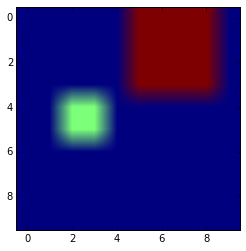

In [92]:
roi_data = np.array(([4, 2, 2, 2], [0, 5, 4, 4]), dtype=np.int64)
label_array = roi.rectangles(roi_data, shape=images1[0].shape)
plt.imshow(label_array)

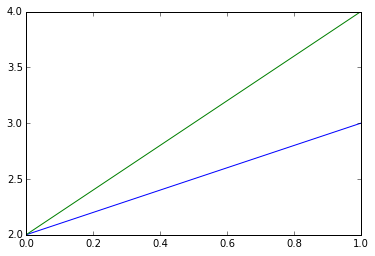

In [93]:
image_sets=[np.asarray(images1), ]

num_times = 2
num_rois = 2

mean_int_sets, index_list = roi.mean_intensity_sets(image_sets, label_array)

combine_intensity = roi.combine_mean_intensity(mean_int_sets, index_list)

plt.plot(combine_intensity)
plt.show()

In [94]:
max_cts = roi.roi_max_counts(image_sets, label_array)
max_cts

4.0

In [110]:
poission_gamma

array([ 0.15609113,  0.17669628,  0.18451672,  0.1837303 ,  0.17729389,
        0.16731627])

In [95]:
mean_int_ring = np.mean(combine_intensity, axis=0)
mean_int_ring

array([ 2.5,  3. ])

In [96]:
num_times=4
norm_bin_edges, norm_bin_centers = xsvs.normalize_bin_edges(num_times,
                                                            num_rois, mean_int_ring, max_cts)

In [97]:
spe_cts_all, std_dev = xsvs.xsvs(image_sets, label_array, timebin_num=2,
                             number_of_img=4, max_cts=max_cts)

In [98]:
spe_cts_all

array([[array([ 0.,  0.,  1.]), array([ nan,  nan,  nan])],
       [array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
        array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.])]], dtype=object)

In [99]:
spe_cts_all[0,0].shape

(3,)

In [100]:
num_times = 3
num_rois = 2
mean_roi = np.array([2.5, 4.0])
max_cts = 5

bin_ed , bin_cen = xsvs.normalize_bin_edges(num_times, num_rois, mean_roi,max_cts)

In [116]:
import time
def xsvs2(image_sets, label_array, timebin_num=2, number_of_img=50,
         max_cts=None):
    """
    This function will provide the probability density of detecting photons
    for different integration time.

    The experimental probability density P(K) of detecting photons K is
    obtained by histogramming the photon counts over an ensemble of
    equivalent pixels and over a number of speckle patterns recorded
    with the same integration time T under the same condition.

    Parameters
    ----------
    image_sets : array
        sets of images

    label_array : array
        labeled array; 0 is background.
        Each ROI is represented by a distinct label (i.e., integer).

    timebin_num : int, optional
        integration times

    number_of_img : int, optional
        number of images

    max_cts : int, optional
       the brightest pixel in any ROI in any image in the image set.

    Returns
    -------
    prob_k_all : array
        probability density of detecting photons

    prob_k_std_dev : array
        standard deviation of probability density of detecting photons

    Note
    ----
    These implementation is based on following references
    References: text [1]_, text [2]_

    .. [1] L. Li, P. Kwasniewski, D. Oris, L Wiegart, L. Cristofolini,
       C. Carona and A. Fluerasu , "Photon statistics and speckle visibility
       spectroscopy with partially coherent x-rays" J. Synchrotron Rad.,
       vol 21, p 1288-1295, 2014.

    .. [2] R. Bandyopadhyay, A. S. Gittings, S. S. Suh, P.K. Dixon and
       D.J. Durian "Speckle-visibilty Spectroscopy: A tool to study
       time-varying dynamics" Rev. Sci. Instrum. vol 76, p  093110, 2005.

    """
    if max_cts is None:
        max_cts = roi.roi_max_counts(image_sets, label_array)

    # number of ROI's
    num_roi = np.max(label_array)

    # create integration times
    time_bin = core.geometric_series(timebin_num, number_of_img)

    # number of items in the time bin
    num_times = len(time_bin)

    # find the label's and pixel indices for ROI's
    labels, indices = corr.extract_label_indices(label_array)

    # number of pixels per ROI
    num_pixels = np.bincount(labels, minlength=(num_roi+1))[1:]

    # probability density of detecting speckles
    prob_k_all = np.zeros([num_times, num_roi], dtype=np.object)
    # square of probability density of detecting speckles
    prob_k_pow_all = np.zeros([num_times, num_roi], dtype=np.object)
    # standard deviation of probability density of detecting photons
    prob_k_std_dev = np.zeros([num_times, num_roi], dtype=np.object)

    # get the bin edges for each time bin for each ROI
    bin_edges = np.zeros((num_times, num_roi), dtype=object)
    for i in range(num_times):
        for j in range(num_roi):
            bin_edges[i, j] = np.arange(max_cts*2**i)

    start_time = time.time()  # used to log the computation time (optionally)

    for i, images in enumerate(image_sets):
        # Ring buffer, a buffer with periodic boundary conditions.
        # Images must be keep for up to maximum delay in buf.
        buf = np.zeros([num_times, timebin_num],
                       dtype=np.object)  # matrix of buffers

        # to track processing each time level
        track_level = np.zeros(num_times)

        # to increment buffer
        cur = np.ones(num_times)*timebin_num

        # to track how many images processed in each level
        img_per_level = np.zeros(num_times, dtype=np.int64)

        prob_k = np.zeros([num_times, num_roi], dtype=np.object)
        prob_k_pow = np.zeros([num_times, num_roi], dtype=np.object)

        for n, img in enumerate(images):
            cur[0] = (1 + cur[0]) % timebin_num
            print "cur"
            print cur
            # read each frame
            # Put the image into the ring buffer.
            buf[0, cur[0] - 1] = (np.ravel(img))[indices]
            print "number ",n
            print buf

            _process(num_roi, 0, cur[0] - 1, buf, img_per_level, labels,
                     max_cts, bin_edges[0, 0], prob_k, prob_k_pow)

            # check whether the number of levels is one, otherwise
            # continue processing the next level
            processing = num_times > 1
            level = 1

            while processing:
                if not track_level[level]:
                    track_level[level] = 1
                    processing = 0
                else:
                    prev = 1 + (cur[level - 1] - 2) % timebin_num
                    cur[level] = 1 + cur[level] % timebin_num

                    buf[level, cur[level]-1] = (buf[level-1,
                                                    prev-1] +
                                                buf[level-1,
                                                    cur[level - 1] - 1])
                    track_level[level] = 0

                    _process(num_roi, level, cur[level]-1, buf, img_per_level,
                             labels, max_cts, bin_edges[level, 0], prob_k,
                             prob_k_pow)
                    level += 1
                    # Checking whether there is next level for processing
                    processing = level < num_times

            prob_k_all += (prob_k - prob_k_all)/(i + 1)
            prob_k_pow_all += (prob_k_pow - prob_k_pow_all)/(i + 1)

            prob_k_std_dev = np.power((prob_k_pow_all -
                                       np.power(prob_k_all, 2)), .5)

    # ending time for the process
    end_time = time.time()

    logger.info("Processing time for XSVS took {0} seconds."
                "".format(end_time - start_time))
    return prob_k_all, prob_k_std_dev


def _process(num_roi, level, buf_no, buf, img_per_level, labels, max_cts,
             bin_edges, prob_k, prob_k_pow):
    """
    Internal helper function. This modifies inputs in place.

    This helper function calculate probability of detecting speckles for
    each integration time.

    Parameters
    ----------
    num_roi : int
        number of ROI's

    level : int
        current time level(integration time)

    buf_no : int
        current buffer number

    buf : array
        image data array to use for XSVS

    img_per_level : int
        to track how many images processed in each level

    labels : array
        labels of the required region of interests(ROI's)

    max_cts: int
        maximum pixel count

    bin_edges : array
        bin edges for each integration times and each ROI

    prob_k : array
        probability density of detecting speckles

    prob_k_pow : array
        squares of probability density of detecting speckles
    """
    img_per_level[level] += 1

    for j in xrange(num_roi):
        roi_data = buf[level, buf_no][labels == j+1]

        spe_hist, bin_edges = np.histogram(roi_data, bins=bin_edges,
                                           normed=True)

        prob_k[level, j] += (spe_hist -
                             prob_k[level, j])/(img_per_level[level])

        prob_k_pow[level, j] += (np.power(spe_hist, 2) -
                                 prob_k_pow[level, j])/(img_per_level[level])


        return None  # modifies arguments in place!

In [117]:
import logging
logger = logging.getLogger(__name__)

spe_cts_a, std=xsvs2(image_sets, label_array, timebin_num=2,
                             number_of_img=4, max_cts=max_cts)

cur
[ 1.  2.]
number  0
[[ array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.])
  0]
 [0 0]]
cur
[ 0.  2.]
number  1
[[ array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.])
  array([ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  3.,  3.,  3.,  3.])]
 [0 0]]
